In [1]:
import tensorflow as tf
import numpy as np
from nbutil import imshow_multi
import os
from PIL import Image
import urllib, cStringIO
import cv2

In [2]:
BATCH_SIZE = 64
MODE = 'TRAIN' # TRAIN/EVAL

In [3]:
attr_file = '../data/celeba/list_attr_celeba.txt'
keys = None
attributes_by_image = {}
for i, line in enumerate(open(attr_file)):
    if i == 1:
        keys = line.split()
    elif i > 1:
        image = os.path.join('../data/celeba/img_align_celeba', line.split()[0])
        values = line.split()[1:]
        attributes_by_image[image] = {attr: val == '1' for attr, val in zip(keys, values)}


In [4]:
# print keys
image_names = attributes_by_image.keys()
attr_vector = np.zeros((len(attributes_by_image), len(keys)))
for i, image_name in enumerate(image_names):
    attrs = attributes_by_image[image_name]
    attr_vector[i] = [(1 if attrs[key] else 0) for key in keys]

from collections import defaultdict
key_value_pair_counts = defaultdict(int)
for attrs in attributes_by_image.itervalues():
    for pair in attrs.iteritems():
        key_value_pair_counts[pair] += 1
n_images = float(len(image_names))

rarity_vector = np.zeros((len(attributes_by_image), len(keys)))
for i, image_name in enumerate(image_names):
    attrs = attributes_by_image[image_name]
    rarity_vector[i] = [n_images / key_value_pair_counts[(key, attrs[key])] for key in keys]

In [5]:
# filename_queue = tf.train.string_input_producer(image_names, num_epochs=None)
# attr_queue = tf.train.input_producer(tf.constant(attr_vector), num_epochs=None)

def create_qs(train):
    filename_tensor = tf.convert_to_tensor(image_names, dtype=tf.string)
    attr_tensor = tf.convert_to_tensor(attr_vector, dtype=tf.float32)
    rarity_tensor = tf.convert_to_tensor(rarity_vector, dtype=tf.float32)
    filename_q, attr_q, rarity_q = tf.train.slice_input_producer([filename_tensor, attr_tensor, rarity_tensor], num_epochs=None, shuffle=True)

    # reader = tf.WholeFileReader()
    # filename, image_data = reader.read(filename_q)
    image_255 = tf.image.decode_jpeg(tf.read_file(filename_q))
    image = tf.reshape(tf.cast(image_255, tf.float32) / 255.0, [218, 178, 3]) # images are 178x218


    def resize_image(image):
        image = tf.random_crop(image, [192, 160, 3])
        return image
    #     image = tf.image.resize_bilinear(img_reshaped, [192, 160])
    #     return tf.reshape(image, [192, 160, 3])
    image = resize_image(image)

    def distort_image(image):
        noise_amt = tf.abs(tf.random_normal([], stddev=0.2))
        distorted_image = image + tf.random_uniform([192, 160, 3], maxval=noise_amt)
        distorted_image = tf.image.random_flip_left_right(distorted_image)
        distorted_image = tf.image.random_brightness(distorted_image, max_delta=0.3)
        distorted_image = tf.image.random_contrast(distorted_image, lower=0.6, upper=1.6)
        # distorted_image = tf.image.per_image_standardization(distorted_image)
        # distorted_image = tf.clip_by_value(distorted_image, 0, 1)
        return distorted_image

    image = distort_image(image) if train else image

    if train:
        images_batch, attrs_batch, rarity_batch = tf.train.shuffle_batch([image, attr_q, rarity_q], batch_size=BATCH_SIZE, capacity=1000, min_after_dequeue=500)
    else:
        images_batch, attrs_batch, rarity_batch = tf.train.batch([image, attr_q, rarity_q], batch_size=BATCH_SIZE, allow_smaller_final_batch=True)
    return images_batch, attrs_batch, rarity_batch

images_batch, attrs_batch, rarity_batch = create_qs(True)
# images_batch_eval, attrs_batch_eval = create_qs(False)

In [6]:
session = tf.Session()
init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
session.run(init_op)
tf.train.start_queue_runners(sess=session)

[<Thread(Thread-4, started daemon 139726081345280)>,
 <Thread(Thread-5, started daemon 139726072952576)>]

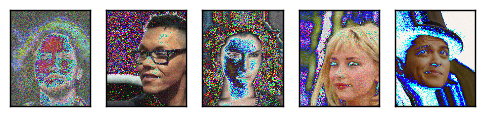

In [7]:
%matplotlib inline

images_, attrs_, rarity_ = session.run([images_batch, attrs_batch, rarity_batch])

imshow_multi(images_[:5])
# for k, val in zip(keys, attrs_[0]):
#     print k, val

In [8]:
dropout_keep_prob = tf.placeholder_with_default(tf.constant(1.0), [], name='dropout_keep_prob')        
from tensorflow.contrib.layers.python.layers import batch_norm

keyed_vars = {}
def join_keys(key1, key2):
    if key1 is None or key2 is None:
        return None
    else:
        return key1 + '.' + key2

def weight_var(shape, stddev=0.1, mean=0.0, weight_decay=0, name=None, key=None):
    initial = tf.truncated_normal(shape, mean=mean, stddev=stddev)
    v = tf.Variable(initial, name=name)
    if weight_decay > 0:
        l2 = tf.nn.l2_loss(v) * weight_decay
        tf.add_to_collection('losses', l2)
    if key: keyed_vars[key] = v
    return v

def create_fc(input, out_size, relu=True, key=None):
    # input_dropped = tf.nn.dropout(input, dropout_keep_prob)
    in_size = input.get_shape()[-1].value
    w = weight_var([in_size, out_size], name='w', key=join_keys(key, 'w'))
    b = weight_var([out_size], mean=0.1, name='b', key=join_keys(key, 'b'))
    x = tf.matmul(input, w)
    return tf.nn.relu(x + b) if relu else x + b

def create_conv(input, out_channels, patch_size=5, stride=1, dropout=False, key=None):
    in_channels = input.get_shape()[-1].value
    w = weight_var([patch_size, patch_size, in_channels, out_channels], name='w', key=join_keys(key, 'w'))
    b = weight_var([out_channels], stddev=0, name='b', mean=0.1, key=join_keys(key, 'b'))
    conv = tf.nn.conv2d(input, w, strides=[1,stride,stride,1], padding='SAME')
    activation = tf.nn.relu(conv + b)
    if dropout: activation = create_dropout(activation)
    return activation

def create_max_pool(inputs, ksize=2, stride=2):
    return tf.nn.max_pool(inputs, ksize=[1, ksize, ksize, 1], strides=[1, stride, stride, 1], padding='SAME')

def create_avg_pool(inputs, ksize=2, stride=2):
    return tf.nn.avg_pool(inputs, ksize=[1, ksize, ksize, 1], strides=[1, stride, stride, 1], padding='SAME')

def create_batch_norm(inputs):
    return batch_norm(inputs, is_training=(MODE == 'TRAIN'), updates_collections=None)

def create_dropout(inputs):
    return tf.nn.dropout(inputs, dropout_keep_prob)

def flatten_tensor(t):
    shape = [s.value for s in t.get_shape()]
    flat_size = 1
    for x in shape[1:]:
        flat_size *= x
    return tf.reshape(t, [-1, flat_size])

In [9]:
def conv_model(image):
    # image size: 192, 160, 3
    conv1 = create_conv(image, 16, patch_size=3, batch_norm=True, key='conv1')
    pool2 = create_max_pool(conv1, ksize=4, stride=4) # [48, 40, 16]
    
    conv3 = create_conv(pool2, 32, patch_size=3, key='conv3')
    pool4 = create_max_pool(conv3) # [24, 40, 32]
    
    conv5 = create_conv(pool4, 32, patch_size=3, batch_norm=True, key='conv5')
    pool6 = create_max_pool(conv5) # [12, 20, 32]
    
    conv7 = create_conv(pool6, 64, patch_size=3, key='conv7')
    pool8 = create_max_pool(conv7) # [6, 10, 64]
    
    conv9 = create_conv(pool8, 32, patch_size=3, key='conv9')
    pool10 = create_max_pool(conv9) # [3, 10, 32]
    
    dropout11 = create_dropout(pool10)
    
    fc12 = create_fc(flatten_tensor(dropout11), 64, key='fc12')
    fc13 = create_fc(fc12, 128, key='fc13')
    return create_fc(fc13, len(keys), relu=False, key='fc14')

def big_conv_model(image):
    # size: 192, 160, 3
    for i, size in enumerate([16, 16, 32, 64, 64]):
        key = 'conv' + str(i)
        image = create_conv(image, size, patch_size=3, batch_norm=True, key=key)
        image = create_avg_pool(image)
    # now we have a 5x64 image:
    image = create_dropout(image)
    image = create_fc(flatten_tensor(image), 256, key='fc1')
    image = create_fc(image, 256, key='fc2')
    return create_fc(image, len(keys), relu=False, key='final')

def facenet1(image):
    # size: 192, 160, 3
    # 64 -> 32 -> 16 -> 8 -> 4
    image = tf.image.resize_bilinear(image, [64, 64])
    for i, size in enumerate([16, 32, 64, 64]):
        key = 'conv' + str(i)
        image = create_conv(image, size, patch_size=3, key=key)
        image = create_batch_norm(image)
        image = create_avg_pool(image)
    # now we have a 4x4x64 image:
    image = create_dropout(image)
    image = create_fc(flatten_tensor(image), 256, key='fc1')
    image = create_fc(image, 256, key='fc2')
    return create_fc(image, len(keys), relu=False, key='fc3')

image_input = tf.placeholder_with_default(images_batch, [None, 192, 160, 3], name='image_input')
actual_attrs = tf.placeholder_with_default(attrs_batch, [None, len(keys)], name='actual_attrs')
rarities = tf.placeholder_with_default(rarity_batch, [None, len(keys)], name='rarities')

attr_logits = facenet1(image_input)
attr_predictions = tf.sigmoid(attr_logits)

In [10]:
loss_by_attr = tf.nn.sigmoid_cross_entropy_with_logits(attr_logits, actual_attrs) * rarities
loss = tf.reduce_sum(loss_by_attr)

learn_rate = tf.placeholder_with_default(tf.constant(0.001), [], name='learn_rate')
optimizer = tf.train.AdamOptimizer(learn_rate)
global_step = global_step = tf.contrib.framework.get_or_create_global_step()
train_step = optimizer.minimize(loss, global_step=global_step)

correct_vals = tf.cast(tf.equal(tf.round(actual_attrs), tf.round(attr_predictions)), tf.float32)
# correct_counts = tf.reduce_sum(tf.cast(tf.equal(tf.round(actual_attrs), tf.round(attr_predictions)), tf.float32), axis=0)
scaled_correctness = correct_vals * rarities
scaled_correctness_avg = tf.reduce_mean(scaled_correctness, axis=0) / tf.reduce_mean(rarities, axis=0)




In [11]:
save_path = 'models/face8'

init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
session.run(init_op)

saver = None
if save_path:
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    saver = tf.train.Saver()
    ckpt = tf.train.get_checkpoint_state(save_path)
    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(session, ckpt.model_checkpoint_path)
        print 'Restored from checkpoint', ckpt.model_checkpoint_path
    else:
        print 'Did not restore from checkpoint'
else:
    print 'Will not save progress'

Restored from checkpoint models/face8/model.ckpt-6500


In [16]:
if MODE == 'TRAIN':
    feed = {dropout_keep_prob: 0.5}
    prev_losses = []
    rolling_acc_sum = 0
    
    while True:
        step_, loss_, _, acc_ = session.run([global_step, loss, train_step, scaled_correctness_avg], feed_dict=feed)
        rolling_acc_sum += acc_
        prev_losses.append(loss_)
        
        # update learn rate:
        feed[learn_rate] = 0.01
        if step_ > 1000:
            feed[learn_rate] = 0.0001
        # if step_ > 3000:
        #     feed[learn_rate] = 0.0001
        # if step_ > 10000:
        #     feed[learn_rate] = 0.00001
        
        if step_ % 50 == 1:
            avg_loss = sum(prev_losses) / len(prev_losses)
            accuracies = rolling_acc_sum / len(prev_losses)
            prev_losses = []
            rolling_acc_sum = 0
            print 'Step: {}, loss: {}, approx epochs: {}'.format(step_, avg_loss, step_ * BATCH_SIZE / float(len(image_names)))
            if step_ % 100 == 1 and accuracies is not 0:
                print {key: val for key, val in zip(keys, list(accuracies))}
        if step_ % 500 == 0 and saver:
            saver.save(session, save_path + '/model.ckpt', global_step=step_)
            print 'Saved'

Step: 8301, loss: 2692.42655888, approx epochs: 2.62224394
{'Sideburns': 0.78173071, 'Black_Hair': 0.75992817, 'Wavy_Hair': 0.6808728, 'Young': 0.67538744, 'Heavy_Makeup': 0.84682274, 'Blond_Hair': 0.86974746, 'Attractive': 0.71972358, '5_o_Clock_Shadow': 0.79024863, 'Wearing_Necktie': 0.81152815, 'Blurry': 0.64789569, 'Double_Chin': 0.78349078, 'Brown_Hair': 0.59408349, 'Mouth_Slightly_Open': 0.55986434, 'Goatee': 0.79669678, 'Bald': 0.87071013, 'Pointy_Nose': 0.6349625, 'Gray_Hair': 0.82032639, 'Pale_Skin': 0.70351642, 'Arched_Eyebrows': 0.73182422, 'Wearing_Hat': 0.84908336, 'Receding_Hairline': 0.71231997, 'Straight_Hair': 0.56051183, 'Big_Nose': 0.70043308, 'Rosy_Cheeks': 0.75905335, 'Oval_Face': 0.59301847, 'Bangs': 0.73311281, 'Male': 0.88266057, 'Mustache': 0.7912364, 'High_Cheekbones': 0.62530029, 'No_Beard': 0.81397855, 'Eyeglasses': 0.76298094, 'Bags_Under_Eyes': 0.68193656, 'Wearing_Necklace': 0.70245194, 'Wearing_Lipstick': 0.87785977, 'Big_Lips': 0.59402728, 'Narrow_Eyes'

KeyboardInterrupt: 

In [ ]:
faceCascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

def load_image(url):
    file = cStringIO.StringIO(urllib.urlopen(url).read())
    return Image.open(file)

def detect_face(pil_image):
    cvimg = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)
    gray = cv2.cvtColor(cvimg, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(30, 30),
        flags = cv2.cv.CV_HAAR_SCALE_IMAGE
    )
    faces = list(faces)
    faces.sort(key=lambda(x,y,w,h): w*h, reverse=True)
    if len(faces):
        return faces[0]
    else:
        return None

def crop_to_face(pil_image):
    target_size = (160, 192)
    face = detect_face(pil_image)
    if face is not None:
        center_x = face[0] + face[2] / 2
        center_y = face[1] + face[3] / 2
        width = int(round(face[2] / 0.65))
        height = width * target_size[1] / target_size[0]
        # height = min(pil_image.size[1], height)
        x = center_x - width/2
        y = center_y - height/2
        cropped = pil_image.crop((x, y, x + width, y + height))
        return cropped.resize(target_size, Image.ANTIALIAS)
    else:
        return pil_image

def eval_pic(pil_image):
    img = np.array(crop_to_face(pil_image))
    imshow_multi([img])
    normalized = session.run(tf.image.per_image_standardization(img))
    predictions_ = session.run(attr_predictions, {image_input: np.array([img])})
    for key, pred in zip(keys, predictions_[0]):
        print key, round(pred * 10) / 10.0
    

In [ ]:
%matplotlib inline

# if MODE == 'EVAL':
#     correct_sum = 0
#     # compute baseline accuracy of a model that just predicts the most likely value for each attribute
#     correct_sum_baseline = 0
#     most_likely = np.round(attr_vector.sum(axis=0, dtype=float) / len(image_names))
#     correct_counts_baseline = tf.reduce_sum(tf.cast(tf.equal(actual_attrs, most_likely), 1.0), axis=0)
    
#     known_total_images = len(image_names)
#     stop_at_count = BATCH_SIZE * 300
#     images_processed = 0
    
#     i = 0
#     while True:
#         correct_, correct_baseline_, preds_ = session.run([correct_counts, correct_counts_baseline, attr_predictions])
#         # print preds_
#         correct_sum += correct_
#         correct_sum_baseline += correct_baseline_
#         images_processed += BATCH_SIZE
#         # this assumes all batches are BATCH_SIZE (the last one might be smaller) but that's okay
#         i += 1
#         if i % 20 == 0:
#             print str(images_processed / float(stop_at_count) * 100) + '% done'
#         if images_processed >= stop_at_count: break
    
#     for key in keys:
#         i = keys.index(key)
#         correct = correct_sum[i]
#         baseline_correct = correct_sum_baseline[i]
#         print key, correct / float(stop_at_count)
#         # print ' baseline:', baseline_correct / float(stop_at_count)
#         # print ''

if MODE == 'EVAL':
    if True:
        meryl_streep = 'https://upload.wikimedia.org/wikipedia/commons/thumb/4/4b/Meryl_Streep_February_2016.jpg/220px-Meryl_Streep_February_2016.jpg'
        obama = 'http://viralcypher.com/wp-content/uploads/2016/11/obama.jpg'
        cpax = 'https://news.brown.edu/files/styles/vertical/public/article_images/Paxson72a_3.jpg?itok=aLoYkVWa'
        n8 = 'https://avatars3.githubusercontent.com/u/3059249?v=3&s=460'
        justin = 'https://scontent.fhan4-1.fna.fbcdn.net/v/t1.0-9/15895316_10207891864551393_3694897809127225461_n.jpg?oh=6946c7c4e072126072ce92bce9dfaa9e&oe=58DBF90E'
        beyonce = 'http://factmag-images.s3.amazonaws.com/wp-content/uploads/2013/12/beyonce-121313.jpg'
        
        url = beyonce
        eval_pic(load_image(url))
    if False:
        images_, predictions_ = session.run([image_input, attr_predictions])
        for x in range(1):
            img = np.clip(images_[x]/2 + 0.5, 0, 1)
            imshow_multi([img])
            for key, pred in zip(keys, predictions_[x]):
                print key, round(pred * 10) / 10.0
    
    if False:
        correctness_sum = 0
        n_batches = 100

        for i in xrange(n_batches):
            correctness_sum += session.run(scaled_correctness_avg)
            if i % 20 == 0:
                print str(i / float(n_batches) * 100) + '% done'

        for key, score in zip(keys, correctness_sum / n_batches):
            print key, score


In [14]:
out_dir = 'models/facenet-weights'

if out_dir:
    var_keys = keyed_vars.keys()
    var_values = session.run([keyed_vars[k] for k in var_keys])
    import struct

    for key, val in zip(var_keys, var_values):
        name = key + '.' + '_'.join(map(str, val.shape))
        weights = val.astype(np.float32)
        if key.startswith('conv'):
            if len(weights.shape) == 4:
                weights = weights.transpose([3,2,0,1])
        elif key.startswith('fc'):
            weights = weights.transpose()
        
        bytes = weights.tobytes()
        open(out_dir + '/' + name + '.weight', 'w').write(bytes)

In [15]:
batchnorm_vals = defaultdict(lambda: [None,None,None]) # (mean, variance,beta)

for v in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES):
    if v.name.startswith('BatchNorm'):
        # print v.name
        params = batchnorm_vals[v.name.split('/')[0]]
        val = session.run(v)
        # print val.shape
        if '/moving_mean' in v.name:
            params[0] = val
        elif '/moving_variance' in v.name:
            params[1] = val
        elif 'beta' in v.name:
            params[2] = val

for key, vals in batchnorm_vals.iteritems():
    data = np.array(vals).astype(np.float32).tobytes()
    # print len(data)
    open(out_dir + '/' + key, 'w').write(data)

In [ ]:
for v in batchnorm_vals['BatchNorm'][1]:
    print v
print batchnorm_vals.keys()